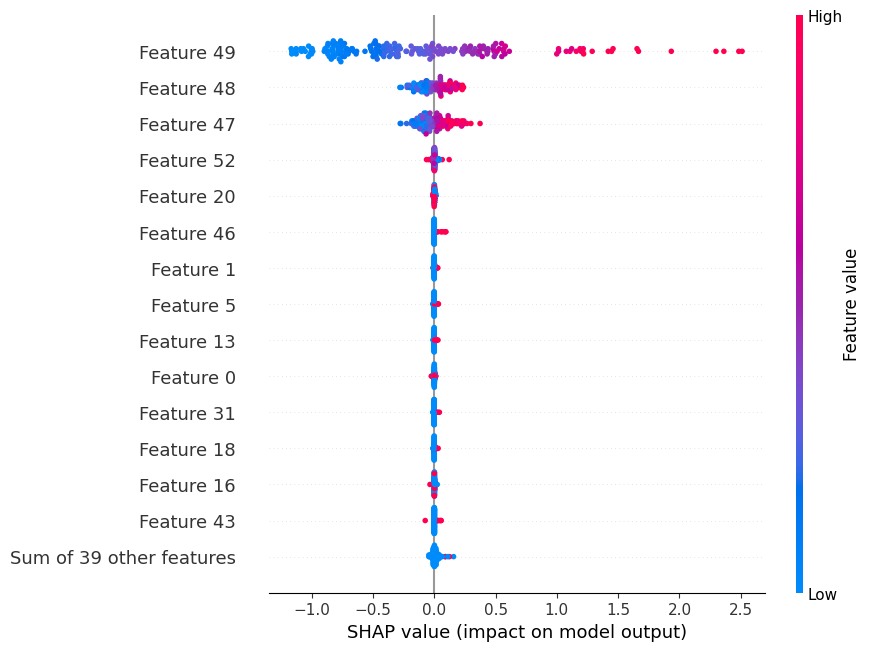

Top 10 Important Features:
    Feature  Mean SHAP
49    None   0.613027
48    None   0.101983
47    None   0.096281
52    None   0.008199
20    None   0.003072
46    None   0.003025
1     None   0.002973
5     None   0.002761
13    None   0.002738
0     None   0.002578
✅ Preprocessor and target scaler saved.

[NOTE] Bayesian hierarchical modeling section can be added later here.


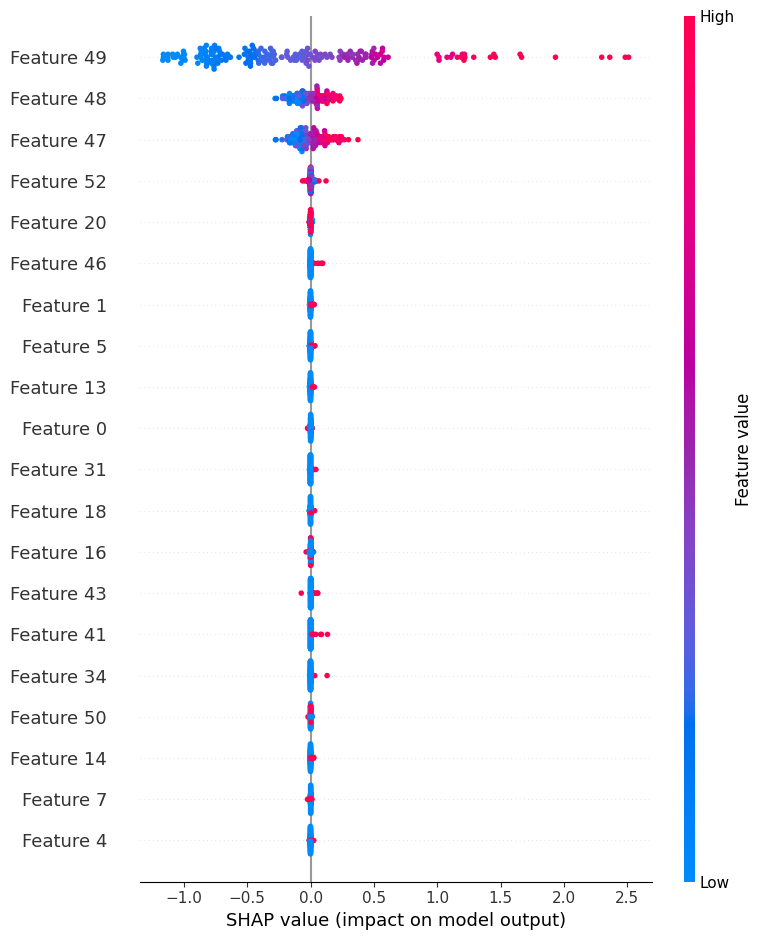

In [8]:
import pandas as pd
import numpy as np
import shap
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import joblib
import os

# Load dataset
df = pd.read_csv('/Users/georgepaul/Desktop/Bayesian-Neural_Network/generated-data/synthetic_supplier_emissions.csv')

target_col = 'Reported_Emissions_kgCO2e'
cat_cols = ['Country', 'Product_Type', 'Material_Type', 'Source', 'Data_Confidence', 'Report_Month']
num_cols = ['Units_Produced', 'Emission_Factor', 'ThirdParty_Estimate', 'Green_Certified', 'Prior_Violations', 'Audit_Score']

X = df[cat_cols + num_cols]
y = df[[target_col]]

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])
X_processed = preprocessor.fit_transform(X).toarray()

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_scaled, test_size=0.2, random_state=42)

# Train surrogate model
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train.ravel())

# SHAP Analysis
explainer = shap.Explainer(rfr, X_train)
shap_values = explainer(X_test, check_additivity=False)

shap.plots.beeswarm(shap_values, max_display=15)

top_features = pd.DataFrame({
    'Feature': shap_values.feature_names,
    'Mean SHAP': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='Mean SHAP', ascending=False)

print("Top 10 Important Features:\n", top_features.head(10))

# Save SHAP summary plot
plt.title("SHAP Feature Importance")
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("/Users/georgepaul/Desktop/Bayesian-Neural_Network/Graphs/shap_summary.png")

# Save preprocessor and target scaler
output_dir = '/Users/georgepaul/Desktop/Bayesian-Neural_Network/models'
os.makedirs(output_dir, exist_ok=True)

joblib.dump(preprocessor, f'{output_dir}/preprocessor.joblib')
joblib.dump(target_scaler, f'{output_dir}/target_scaler.joblib')

print('Preprocessor and target scaler saved.')